<a href="https://colab.research.google.com/github/roses-and-thorns/BCS_Introductory_Comp_Neuro/blob/main/Mini_Project_BCS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***
***
# **Introductory Computational Neuroscience**

This notebook was used for analysis in the mini-project for this project titled, 'The Structure of Mouse Social Behaviour'. We are grateful to Neuromatch Academy for providing valuable course content and this starter notebook.

> Project Mentors: Aniruddh Pramod, Tanuja Kaleli
> Project Mentees: Aabha Kandhare, Debarpita Dash, Eeshwari Sunkersett, Manasvi Nidugala, Srishti Chandra and Yeleena Vimal

## Starter Code
***

<h1>
Behavior classification starter kit 🐁🐀
</h1>
This code is adapted from a notebook created by Dipam Chakraborty at AIcrowd for the <a href=https://www.aicrowd.com/challenges/multi-agent-behavior-representation-modeling-measurement-and-applications>Multi-Agent Behavior Challenge</a>.


# Import necessary modules and packages 📚


In [ ]:
import os
import json
import numpy as np
import pandas as pd

# Download the dataset 📲

The CalMS21 dataset is hosted by Caltech at https://data.caltech.edu/records/1991. For now, we'll focus on the Task 1 data, which can be downloaded as follows:

In [ ]:
# @title Download and unzip the data
import os, requests, zipfile

fname = 'task1.zip'
url = "https://data.caltech.edu/records/s0vdx-0k302/files/task1_classic_classification.zip?download=1"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)
else:
  print('Data have already been downloaded!!!')

if not os.path.exists('task1_classic_classification'):
  # Unzip the file
  with zipfile.ZipFile(fname, 'r') as zip_ref:
    zip_ref.extractall('.')


# Download the script
fname = 'calms21_convert_to_npy.py'
url = "https://data.caltech.edu/records/s0vdx-0k302/files/calms21_convert_to_npy.py?download=1"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

The dataset files are stored as json files. For ease of handling, we'll first convert them to .npy files using the script we just downloaded, `calms21_convert_to_npy.py`. The output of this script is a pair of files, `calms21_task1_train.npy` and `calms21_task1_test.npy`.

If you include the optional `parse_treba` flag, the script will create files `calms21_task1_train_features.npy` and `calms21_task1_test_features.npy`, which contain 32 features created using <a href=https://openaccess.thecvf.com/content/CVPR2021/html/Sun_Task_Programming_Learning_Data_Efficient_Behavior_Representations_CVPR_2021_paper.html>Task Programming</a>.



In [ ]:

!python calms21_convert_to_npy.py  --input_directory '.' --output_directory '.'
!python calms21_convert_to_npy.py  --input_directory '.' --output_directory '.' --parse_treba

Saving ./calms21_task1_test
Saving ./calms21_task1_train
Saving ./calms21_task1_test_features
Saving ./calms21_task1_train_features


#Load the data 💾
The following loader function can be used to unpack the `.npy` files containing your train and test sets.

In [ ]:
def load_task1_data(data_path):
  """
  Load data for task 1:
      The vocaubulary tells you how to map behavior names to class ids;
      it is the same for all sequences in this dataset.
  """
  data_dict = np.load(data_path, allow_pickle=True).item()
  dataset = data_dict['annotator-id_0']
  # Get any sequence key.
  sequence_id = list(data_dict['annotator-id_0'].keys())[0]
  vocabulary = data_dict['annotator-id_0'][sequence_id]['metadata']['vocab']
  return dataset, vocabulary

In [ ]:
training_data, vocab = load_task1_data('./calms21_task1_train.npy')
test_data, _ = load_task1_data('./calms21_task1_test.npy')

## Dataset Specifications

`training_data` and `test_data` are both dictionaries with a key for each Sequence in the dataset, where a Sequence is a single resident-intruder assay. Each Sequence contains the following fields:

<ul>
<li><b>keypoints</b>: tracked locations of body parts on the two interacting mice. These are produced using a Stacked Hourglass network trained on 15,000 hand-labeled frames.
<ul>
<li>Dimensions: (# frames) x (mouse ID) x (x, y coordinate) x (body part).
<li>Units: pixels; coordinates are relative to the entire image. Original image dimensions are 1024 x 570.
</ul>
<li><b>scores</b>: confidence estimates for the tracked keypoints.
<ul>
<li>Dimensions: (# frames) x (mouse ID) x (body part).
<li>Units: unitless, range 0 (lowest confidence) to 1 (highest confidence).
</ul>
<li> <b>annotations</b>: behaviors id as an integer annotated at each frame by a domain expert. See below for the behavior id to behavior name mappings.
<ul>
<li>Dimensions: (# frames) .
</ul>
<li><b>metadata</b>: The recorded metadata is annotator_id which is represented by an int, and the vocab, containing a dictionary which maps behavior names to integer ids in annotations.
</ul>

The 'taskprog_features' file contains the additional field:

<ul>
<li><b>features</b>: pre-computed features from a model trained with task programming on the trajectory data of the CalMS21 unlabeled videos set.
<ul>
<li>Dimensions: (# frames) x (feature dim = 32).
</li>
</ul>
</ul>

<b>NOTE:</b> for all keypoints, mouse 0 is the resident (black) mouse and mouse 1 is the intruder (white) mouse. There are 7 tracked body parts, ordered (nose, left ear, right ear, neck, left hip, right hip, tail base).

## What does the data look like? 🔍

### Data overview

As described above, our dataset consists of train and test sets, which are both dictionaries of Sequences, and an accompanying vocabulary telling us which behavior is which:

In [ ]:
print("Sample dataset keys: ", list(training_data.keys())[:3])
print("Vocabulary: ", vocab)
print("Number of train Sequences: ", len(training_data))
print("Number of test Sequences: ", len(test_data))

Sample dataset keys:  ['task1/train/mouse001_task1_annotator1', 'task1/train/mouse002_task1_annotator1', 'task1/train/mouse003_task1_annotator1']
Vocabulary:  {'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
Number of train Sequences:  70
Number of test Sequences:  19


### Sample overview
Next let's take a look at one example Sequence:

In [ ]:
sequence_names = list(training_data.keys())
sample_sequence_key = sequence_names[1]
single_sequence = training_data[sample_sequence_key]
print("Name of our sample sequence: ", sample_sequence_key)
print("Sequence keys: ", single_sequence.keys())
print("Sequence metadata: ", single_sequence['metadata'])
print(f"Number of Frames in Sequence \"{sample_sequence_key}\": ", len(single_sequence['annotations']))
print(f"Keypoints data shape of Sequence \"{sample_sequence_key}\": ", single_sequence['keypoints'].shape)

Name of our sample sequence:  task1/train/mouse002_task1_annotator1
Sequence keys:  dict_keys(['keypoints', 'scores', 'annotations', 'metadata'])
Sequence metadata:  {'annotator-id': 0, 'vocab': {'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}}
Number of Frames in Sequence "task1/train/mouse002_task1_annotator1":  19343
Keypoints data shape of Sequence "task1/train/mouse002_task1_annotator1":  (19343, 2, 2, 7)


# Helper functions for visualization 💁


This cell contains some helper functions that we'll use to create an animation of the mouse movements. You can ignore the contents, but be sure to run it or the next section won't work.

*Basically this plots out each mouse as a set of points. So you can understand it better, and also so you don't need to actually see mice mating.*


In [ ]:
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import colors
from matplotlib import rc
import matplotlib.patches as mpatches

rc('animation', html='jshtml')

# Note: Image processing may be slow if too many frames are animated.

# Plotting constants
FRAME_WIDTH_TOP = 1024
FRAME_HEIGHT_TOP = 570

RESIDENT_COLOR = 'lawngreen'
INTRUDER_COLOR = 'skyblue'

PLOT_MOUSE_START_END = [(0, 1), (0, 2), (1, 3), (2, 3), (3, 4),
                        (3, 5), (4, 6), (5, 6), (1, 2)]
class_to_color = {'other': 'white', 'attack' : 'red', 'mount' : 'green',
                  'investigation': 'orange'}
class_to_number = {s: i for i, s in enumerate(vocab)}
number_to_class = {i: s for i, s in enumerate(vocab)}


def num_to_text(anno_list):
  return np.vectorize(number_to_class.get)(anno_list)


def set_figax():
  fig = plt.figure(figsize=(6, 4))

  img = np.zeros((FRAME_HEIGHT_TOP, FRAME_WIDTH_TOP, 3))

  ax = fig.add_subplot(111)
  ax.imshow(img)

  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  return fig, ax


def plot_mouse(ax, pose, color):
  # Draw each keypoint
  for j in range(7):
    ax.plot(pose[j, 0], pose[j, 1], 'o', color=color, markersize=5)

  # Draw a line for each point pair to form the shape of the mouse

  for pair in PLOT_MOUSE_START_END:
    line_to_plot = pose[pair, :]
    ax.plot(line_to_plot[:, 0], line_to_plot[
            :, 1], color=color, linewidth=1)


def animate_pose_sequence(video_name, keypoint_sequence, start_frame = 0, stop_frame = 100,
                          annotation_sequence = None):
  # Returns the animation of the keypoint sequence between start frame
  # and stop frame. Optionally can display annotations.
  seq = keypoint_sequence.transpose((0,1,3,2))

  image_list = []

  counter = 0
  for j in range(start_frame, stop_frame):
    if counter%20 == 0:
      print("Processing frame ", j)
    fig, ax = set_figax()
    plot_mouse(ax, seq[j, 0, :, :], color=RESIDENT_COLOR)
    plot_mouse(ax, seq[j, 1, :, :], color=INTRUDER_COLOR)

    if annotation_sequence is not None:
      annot = annotation_sequence[j]
      annot = number_to_class[annot]
      plt.text(50, -20, annot, fontsize=16,
               bbox=dict(facecolor=class_to_color[annot], alpha=0.5))

    ax.set_title(
        video_name + '\n frame {:03d}.png'.format(j))

    ax.axis('off')
    fig.tight_layout(pad=0)
    ax.margins(0)

    fig.canvas.draw()
    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(),
                                    dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(
        fig.canvas.get_width_height()[::-1] + (3,))

    image_list.append(image_from_plot)

    plt.close()
    counter = counter + 1

  # Plot animation.
  fig = plt.figure()
  plt.axis('off')
  im = plt.imshow(image_list[0])

  def animate(k):
      im.set_array(image_list[k])
      return im,
  ani = animation.FuncAnimation(fig, animate, frames=len(image_list), blit=True)
  return ani


def plot_behavior_raster(annotation_sequence, start_frame=0,
                         stop_frame=100,
                         title="Behavior Labels"):
  # Plot annotations as a behavior raster

  # Map annotations to a number.
  annotation_num = []
  for item in annotation_sequence[start_frame:stop_frame]:
    annotation_num.append(class_to_number[item])

  all_classes = list(set(annotation_sequence[start_frame:stop_frame]))

  cmap = colors.ListedColormap(['red', 'orange', 'green', 'white'])
  bounds=[-0.5, 0.5, 1.5, 2.5, 3.5]
  norm = colors.BoundaryNorm(bounds, cmap.N)

  height = 200
  arr_to_plot = np.repeat(np.array(annotation_num)[:, np.newaxis].transpose(),
                                                  height, axis = 0)

  fig, ax = plt.subplots(figsize = (16, 3))
  ax.imshow(arr_to_plot, interpolation='none',cmap=cmap, norm=norm)

  ax.set_yticks([])
  ax.set_xlabel('Frame Number')
  plt.title(title)

  legend_patches = []
  for item in all_classes:
    legend_patches.append(mpatches.Patch(color=class_to_color[item], label=item))

  plt.legend(handles=legend_patches,loc='center left', bbox_to_anchor=(1, 0.5))

  plt.tight_layout()

# Visualize the animals' movements 🎥

Let's make some gifs of our sample sequence to get a sense of what the raw data looks like! You can change the values of `start_frame` and `stop_frame` to look around.

Processing frame  5000
Processing frame  5020
Processing frame  5040
Processing frame  5060
Processing frame  5080


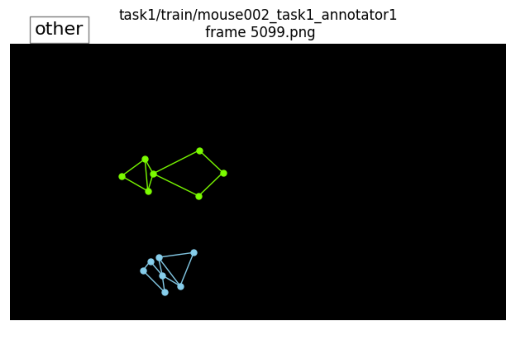

In [ ]:
keypoint_sequence = single_sequence['keypoints']
annotation_sequence = single_sequence['annotations']

ani = animate_pose_sequence(sample_sequence_key,
                            keypoint_sequence,
                            start_frame=5000,
                            stop_frame=5100,
                            annotation_sequence=annotation_sequence)

# Display the animaion on colab
ani

### We can also look at a **behavior raster**, which shows what behavior was annotated on each frame of this video.

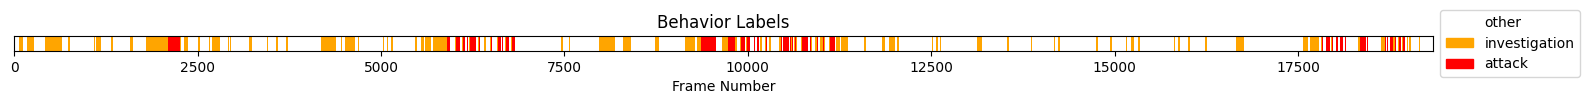

In [ ]:
annotation_sequence = single_sequence['annotations']
text_sequence = num_to_text(annotation_sequence)

plot_behavior_raster(
    text_sequence,
    start_frame=0,
    stop_frame=len(annotation_sequence)
    )

# Basic exploratory data analysis 🤓
Each Sequence has different amounts of each behavior, depending on what the mice do during the assay. Here, we get the percentage of frames of each behavior in each sequence. We can use this to split the training set into train and validation sets in a stratified way.

In [ ]:
def get_percentage(sequence_key):
  anno_seq = num_to_text(training_data[sequence_key]['annotations'])
  counts = {k: np.mean(np.array(anno_seq) == k)*100.0 for k in vocab}
  return counts


anno_percentages = {k: get_percentage(k) for k in training_data}
anno_perc_df = pd.DataFrame(anno_percentages).T
print("Percentage of frames in every sequence for every class")
anno_perc_df.head()

Percentage of frames in every sequence for every class


attack  investigation      mount  \
task1/train/mouse001_task1_annotator1  0.000000      15.788242  30.251826   
task1/train/mouse002_task1_annotator1  9.067880      22.757587   0.000000   
task1/train/mouse003_task1_annotator1  0.000000      13.757374  13.167448   
task1/train/mouse004_task1_annotator1  0.000000      16.440199   7.735773   
task1/train/mouse005_task1_annotator1  7.516398      13.614607   0.000000   

                                           other  
task1/train/mouse001_task1_annotator1  53.959933  
task1/train/mouse002_task1_annotator1  68.174533  
task1/train/mouse003_task1_annotator1  73.075178  
task1/train/mouse004_task1_annotator1  75.824028  
task1/train/mouse005_task1_annotator1  78.868995

## Percent of frames of each behavior in the full training set
Having looked at behavior distributions in a couple example Sequences, let's now look at the average over the entire training set.

In [ ]:
all_annotations = []
for sk in training_data:
  anno = training_data[sk]['annotations']
  all_annotations.extend(list(anno))

all_annotations = num_to_text(all_annotations)
classes, counts = np.unique(all_annotations, return_counts=True)
pd.DataFrame({"Behavior": classes,
              "Percentage Frames": counts/len(all_annotations)*100.0})

Behavior  Percentage Frames
0         attack           2.765009
1  investigation          28.876113
2          mount           5.635781
3          other          62.723097

***
# Our Code Starts Here
***

# Question 1 - Is behaviour stationary?
- Visualise behaviour rasters for several sequences
- Plot the likelihood of observing attack, mounting and sniffing as a function of time


## Visualising Raster Plots

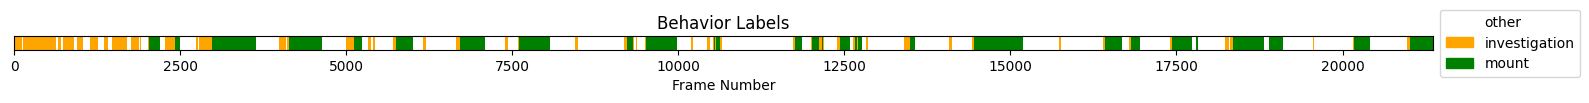

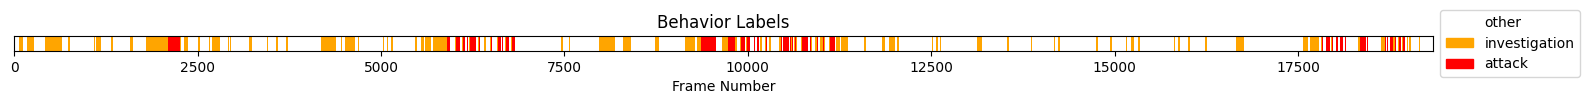

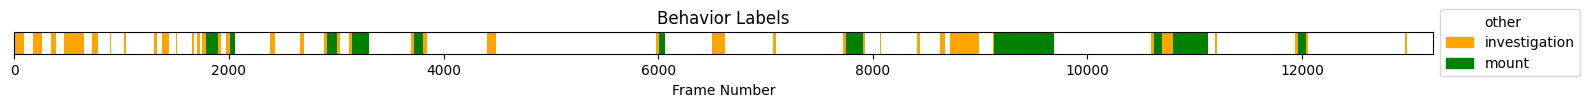

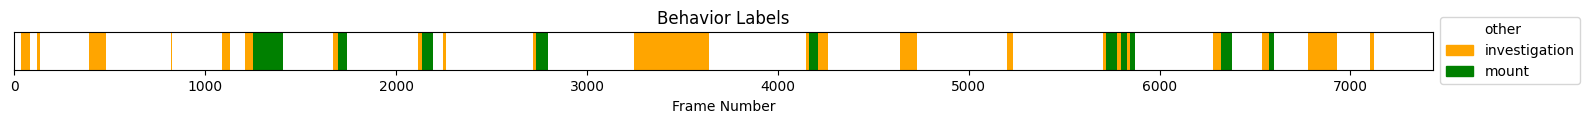

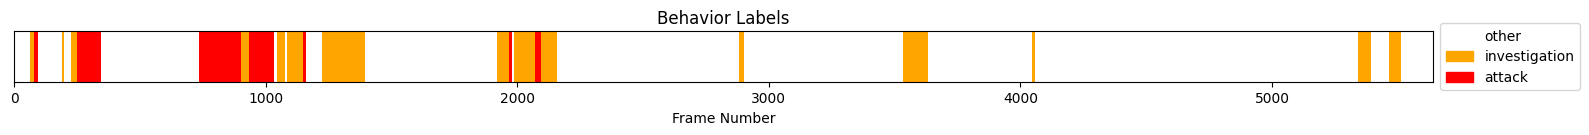

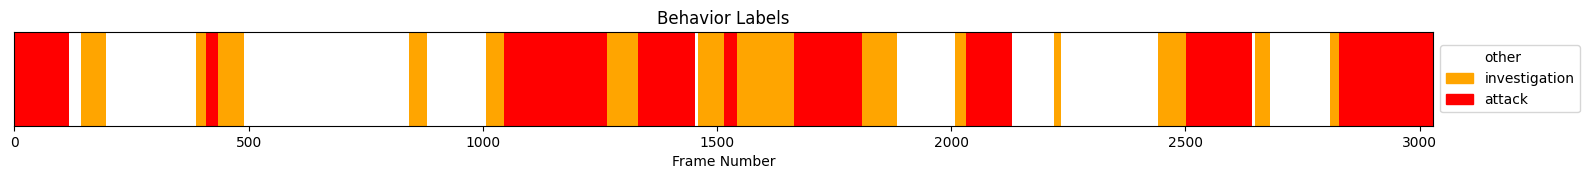

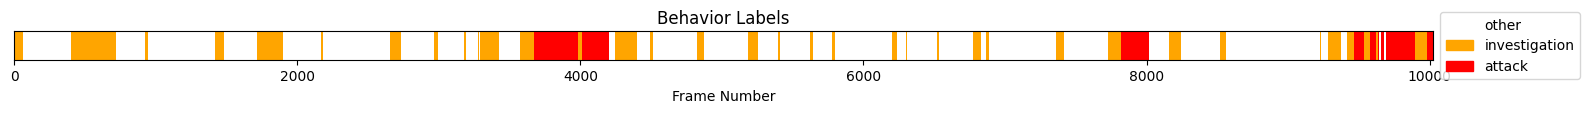

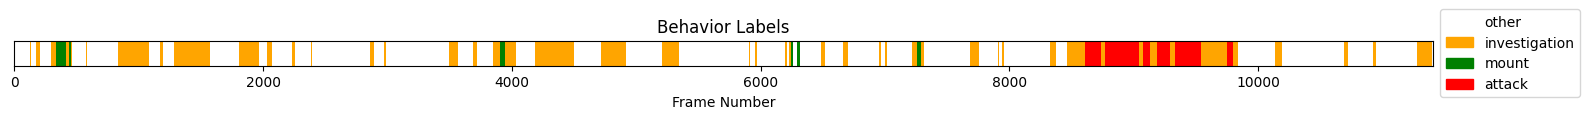

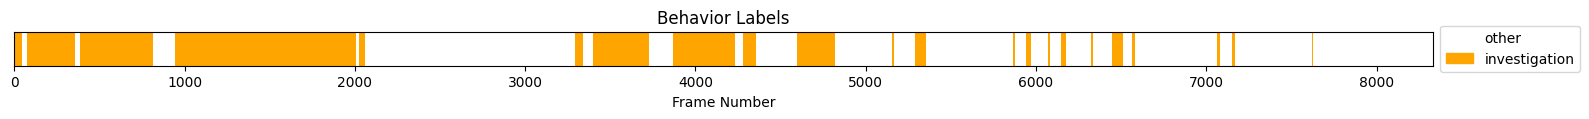

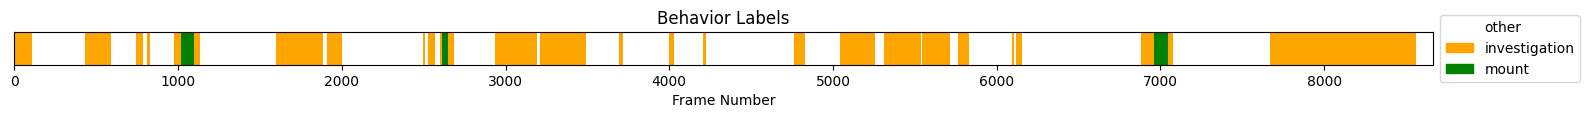

In [ ]:
#VISUALISING RASTER PLOTS
def num_to_text(anno_list):
  return np.vectorize(number_to_class.get)(anno_list)

sequence_names = list(training_data.keys())

for i in sequence_names[:10]:
   single_sequence = training_data[i]
   annotation_sequence =single_sequence['annotations']
   text_sequence = num_to_text(annotation_sequence)
   plot_behavior_raster(text_sequence, start_frame=0,stop_frame=len(annotation_sequence))   #helper function


## Plotting Likelihood

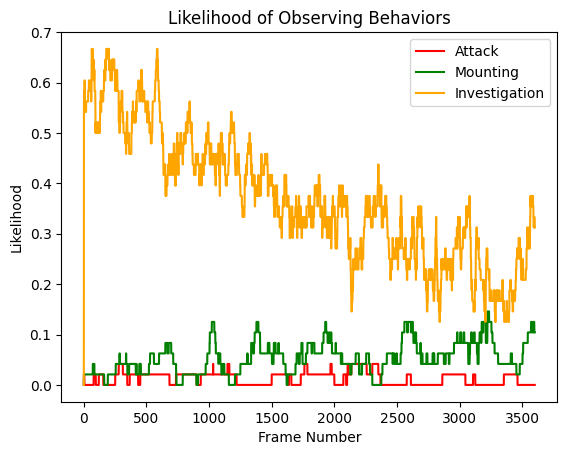

In [ ]:
import logging
logging.getLogger('matplotlib').setLevel(level=logging.CRITICAL)
class_to_color = {'other': 'white', 'attack': 'red', 'mount': 'green', 'investigation': 'orange'}
class_to_number = {s: i for i, s in enumerate(vocab)}
number_to_class = {i: s for i, s in enumerate(vocab)}

def num_to_text(anno_list):
    return np.vectorize(number_to_class.get)(anno_list)

sequence_names = list(training_data.keys())

#Creating nested list valid_seqs with annotations list of sequences having no. of frames greater than 3600
valid_seqs_annot = [training_data[seq]['annotations'][:2*30*60] for seq in sequence_names if len(training_data[seq]['annotations'])>2*30*60]

attack_counts = []
mount_counts = []
investigate_counts = []

for frame_number in range(2*30*60):                  #loop calculating number of instances of attack, mount and investigate for a particular frame number over all valid_seqs_annot
  attacks = sum([1 for seq in valid_seqs_annot if seq[frame_number]==0])
  mounts = sum([1 for seq in valid_seqs_annot if seq[frame_number]==2])
  investigates = sum([1 for seq in valid_seqs_annot if seq[frame_number]==1])
  attack_counts.append(attacks)
  mount_counts.append(mounts)
  investigate_counts.append(investigates)

attack_fracs = [x/len(valid_seqs_annot) for x in attack_counts]            #calculating likelihood for every sequence in valid_seqs
mount_fracs = [x/len(valid_seqs_annot) for x in mount_counts]
investigate_fracs = [x/len(valid_seqs_annot) for x in investigate_counts]

frames = np.arange(2*30*60)

plt.plot(frames, attack_fracs, color='red', label='Attack')
plt.plot(frames, mount_fracs, color='green', label='Mounting')
plt.plot(frames, investigate_fracs, color='orange', label='Investigation')
plt.xlabel('Frame Number')
plt.ylabel('Likelihood')
plt.title('Likelihood of Observing Behaviors')
plt.legend()
plt.show()

### Takeaways

> We can see that as the time passes, the likelihood of investigative behaviour by the resident mouse decreases as it gains information and decides on a fight/mate action.

> We can also see that mounting and attack have similar likelihoods of occuring, with mounting being slightly higher. This may be due to biases in the dataset (such as the fact that we have more data with female intruder mice than male intruder mice)

> Behaviour does not appear to be stationary

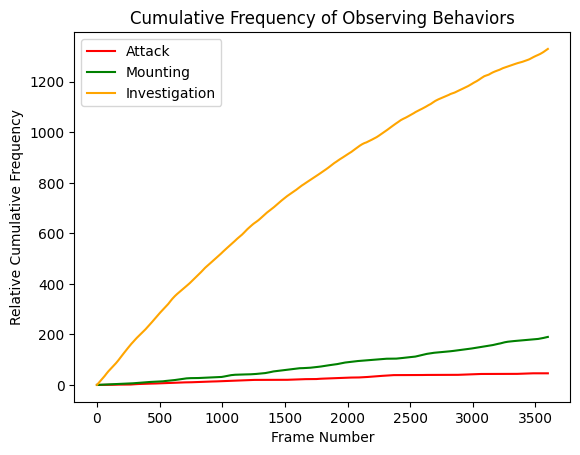

In [ ]:
#cumulative sum of all attack, mount, investigate instances in valid_seqs_annot
frames = np.arange(2*30*60)
attack_cum_counts = np.cumsum(np.array(attack_counts))/len(valid_seqs_annot*frames)
mount_cum_counts = np.cumsum(np.array(mount_counts))/len(valid_seqs_annot*frames)
investigate_cum_counts = np.cumsum(np.array(investigate_counts))/len(valid_seqs_annot*frames)
plt.plot(frames, attack_cum_counts, color='red', label='Attack')
plt.plot(frames, mount_cum_counts, color='green', label='Mounting')
plt.plot(frames, investigate_cum_counts, color='orange', label='Investigation')
plt.xlabel('Frame Number')
plt.ylabel('Relative Cumulative Frequency')
plt.title('Cumulative Frequency of Observing Behaviors')
plt.legend()
plt.show()

# Question 2 - Feature Extraction
Create and visualise some handcrafted features characterising the posture, such as position, velocity, joint angle, inter-animal distance, etc.

## Features

In [ ]:
import numpy as np
import math

#POSITIONS
def position(keypoint_sequence):
  resident=[]
  intruder=[]

  resident = [(np.mean(frame[0][0]),np.mean(frame[0][1])) for frame in keypoint_sequence]
  intruder = [(np.mean(frame[1][0]),np.mean(frame[1][1])) for frame in keypoint_sequence]
  return resident,intruder

#DISTANCES
def distances(intruder,resident):
  interdist=[]
  for i,j in zip(intruder,resident):
    k = math.dist(i,j)
    interdist.append(k)
  return interdist

#ANGLES
def getAngle(a0,a1,b0,b1,c0,c1):
    vec1 = [(b0-a0),(b1-a1)]
    vec2 = [(c0-a0),(c1-a1)]
    dot = lambda x,y: x[0]*y[0] + x[1]*y[1]
    dot_prod = dot(vec1,vec2)
    mag1 = dot(vec1,vec1)**0.5
    mag2 = dot(vec2,vec2)**0.5
    cos_ = dot_prod/mag1/mag2
    cos_ = min(max(cos_, -1), 1)
    angle = math.acos(cos_)
    ang = math.degrees(angle)
    if (ang>180):
        return 360 - ang
    return ang



def angle_from(keypoint_sequence):
  angle_from=[]
  for time in keypoint_sequence:
      i = time[0]
      t=getAngle(i[0][3],i[1][3],i[0][0],i[1][0],i[0][6],i[1][6])
      angle_from.append(t)
  return angle_from

for i in sequence_names:
  sample_sequence_key = sequence_names[1]
  single_sequence = training_data[sample_sequence_key]
  keypoint_sequence = single_sequence['keypoints']
  position(keypoint_sequence)
  angle_from(keypoint_sequence)

In [ ]:
# Velocity
resident = [(np.mean(frame[0][0]),np.mean(frame[0][1])) for frame in keypoint_sequence]
vresident = [(((resident[pos+1][0]-resident[pos][0])/1),((resident[pos+1][1]-resident[pos][1])/1)) for pos in range(len(resident)-1)]
net_vresident=[math.sqrt((vresident[pos][0])**2 +(vresident[pos][1])**2 ) for pos in range(len(resident)-1)]

intruder = [(np.mean(frame[1][0]),np.mean(frame[1][1])) for frame in keypoint_sequence]
vintruder = [(((intruder[pos+1][0]-intruder[pos][0])/1), ((intruder[pos+1][1]-intruder[pos][1])/1)) for pos in range(len(intruder)-1)]
net_vintruder=[math.sqrt((vintruder[pos][0])**2 +(vintruder[pos][1])**2) for pos in range(len(intruder)-1)]

## Plots

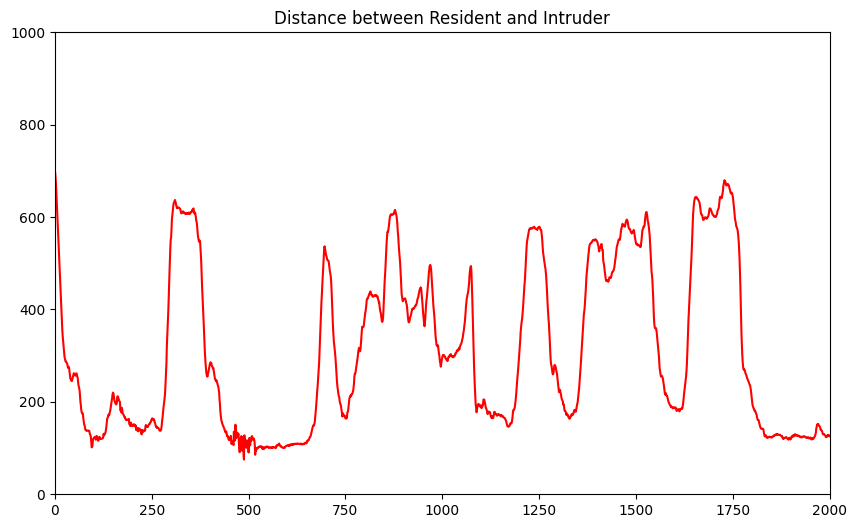

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

interdist = distances(intruder, resident)
x = np.arange(len(interdist))
y = interdist
plt.figure(figsize=(10, 6))
plt.plot(x, y, color='r')
plt.ylim(0, 1000)
plt.xlim(0, 2000)
plt.title('Distance between Resident and Intruder')
plt.show()

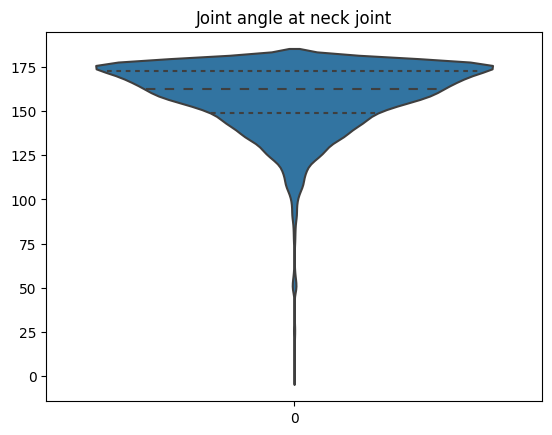

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

angles_list = angle_from(keypoint_sequence)


plt.figure()
sns.violinplot(data=angles_list, inner='quart')
plt.title("Joint angle at neck joint")
plt.show()

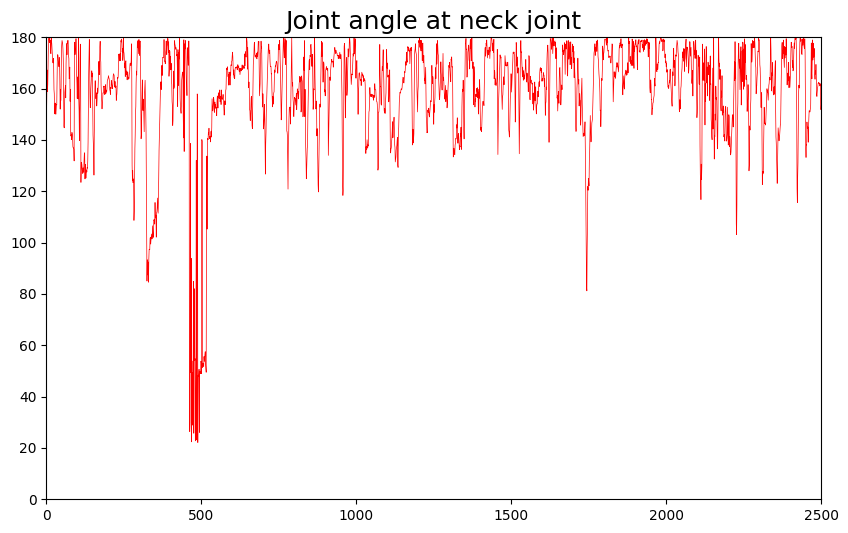

[149.7641947770835, 149.62447942420653, 159.97873738857797, 167.24622759907518, 158.8014393524906, 161.67634099408858, 169.8499717435345, 176.0893566240209, 179.19979828380517, 179.75780913777496, 178.0662197040291, 179.49432844333091, 177.87736782343927, 178.82403926994976, 174.69752733080415, 173.6158360604875, 179.89685739402168, 178.89118787224038, 177.3857832694861, 175.1473935126696, 173.45303153707795, 170.29334759066023, 169.98576937107134, 171.81887737481182, 168.4206869536658, 159.6380482906782, 157.98330699304069, 150.1642329140015, 151.67556340066005, 154.37223030280688, 151.4508119380091, 150.0247738591867, 151.6425378287244, 153.90374054193217, 153.6559342540066, 162.35188082908834, 172.91134345045214, 173.24756917446217, 172.9010706637954, 170.72098176283285, 169.90142313657086, 168.53068146933856, 172.16625425121887, 170.70952246452723, 162.79794709463363, 152.00405345010537, 159.64866002480463, 155.3235118462193, 160.3241814019472, 173.81766948689207, 177.0707785805384

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
angles_list = angle_from(keypoint_sequence)
x = np.arange(len(angles_list))
y = angles_list
plt.figure(figsize=(10, 6))
plt.plot(x, y, color='r', linewidth=0.5)
plt.ylim(0, 180)
plt.xlim(0, 2500)
plt.title('Joint angle at neck joint', fontsize=18)
plt.show()
print(angles_list)

# Question 3 - Are these features modulated by behaviour?
- Look into event-triggered-averages of your features, triggering on the onset or offset of attack/mounting/investigation.
- Do you see any features modulated by behaviour?


In [ ]:
new_seq=[]
new_annot_seq=[]
new_keypoint_seq=[]

#creating lists of seq and annotation seq with number of frames > 3600
for i in sequence_names:
  single_sequence = training_data[i]
  annotation_sequence =single_sequence['annotations']
  if len(annotation_sequence)>2*60*30:
    new_seq.append(i)
    new_annot_seq.append(single_sequence['annotations'])
    new_keypoint_seq.append(single_sequence['keypoints'])


In [ ]:
annotation_sequence=new_annot_seq[0]
keypoint_sequence=new_keypoint_seq[0]

In [ ]:
# Function for finding index where a change to a different occurs
def find_change_indices(annotation_sequence):
    change_indices = []
    prev_element = None

    for i, element in enumerate(annotation_sequence):
        if element != prev_element:
            change_indices.append(i)
            prev_element = element

    return change_indices


In [ ]:
def changes_in_behavior_points(annotation_sequence,change_at_timeframeno):
  """Returns: 3 lists with the change-points
              for attack, mounting and investigation"""
  changetoattack_frame=[]
  changetomount_frame=[]
  changetoinvest_frame=[]

  for timeframeno in change_at_timeframeno:
    if annotation_sequence[timeframeno]==0:
      changetoattack_frame.append(timeframeno)
    elif annotation_sequence[timeframeno]==1:
      changetoinvest_frame.append(timeframeno)
    elif annotation_sequence[timeframeno]==2:
      changetomount_frame.append(timeframeno)

  return changetoattack_frame,changetomount_frame, changetoinvest_frame

##Angles



In [ ]:
def make_angles_list(changetobehavior,keypoint_sequence):
  angles_list=[]
  for i in changetobehavior:
    keypoints= keypoint_sequence[i-1]
    resident_keypoint=keypoints[0]
    t=getAngle(resident_keypoint[0][3],resident_keypoint[1][3],resident_keypoint[0][0],resident_keypoint[1][0],resident_keypoint[0][6],resident_keypoint[1][6])
    angles_list.append(t)
  return angles_list

In [ ]:
def get_change_angles_dict(annotation_sequence,keypoint_sequence):

  change_at_timeframeno=find_change_indices(annotation_sequence)

  changetoattack_frame,changetomount_frame, changetoinvest_frame= changes_in_behavior_points(annotation_sequence,change_at_timeframeno)
  angles_mounting=make_angles_list(changetomount_frame,keypoint_sequence)
  angles_investigating=make_angles_list(changetoinvest_frame,keypoint_sequence)
  angles_attacking=make_angles_list(changetoattack_frame,keypoint_sequence)
  angles_dict={}
  angles_dict['mounting']=angles_mounting
  angles_dict['attacking']=angles_attacking
  angles_dict['investigating']=angles_investigating

  return angles_dict

In [ ]:
change_angles_dict = get_change_angles_dict(annotation_sequence,keypoint_sequence)

##Inter Mouse Distance

In [ ]:
import math
def dist_bw_mice(resident, intruder):
  interdist=[]
  for i,j in zip(intruder,resident):
    k = math.dist(i,j)
    interdist.append(k)
  return interdist


In [ ]:
def generate_behavior_list(time_frame_list):
  resident = [(np.mean(frame[0][0]),np.mean(frame[0][1])) for frame in keypoint_sequence]
  intruder = [(np.mean(frame[1][0]),np.mean(frame[1][1])) for frame in keypoint_sequence]
  new_resident_points=[]
  new_intruder_points=[]
  for i in time_frame_list:
    new_resident_points.append(resident[i])
    new_intruder_points.append(intruder[i])
  return new_resident_points, new_intruder_points

In [ ]:
def get_intermouse_dist_dict(annotation_sequence,keypoint_sequence):
   time_frame_no=find_change_indices(annotation_sequence)
   changetoattack_frame,changetomount_frame, changetoinvest_frame= changes_in_behavior_points(annotation_sequence,time_frame_no)

   attack_resident_points, attack_intruder_points=generate_behavior_list(changetoattack_frame)
   intermouse_attack_dist=dist_bw_mice(attack_resident_points, attack_intruder_points)


   invest_resident_points, invest_intruder_points=generate_behavior_list(changetoinvest_frame)
   intermouse__invest_dist=dist_bw_mice(invest_resident_points, invest_intruder_points)

   mount_resident_points, mount_intruder_points=generate_behavior_list(changetomount_frame)
   intermouse__mount_dist=dist_bw_mice(mount_resident_points, mount_intruder_points)

   intermouse_dist_dict={}

   intermouse_dist_dict['mounting']=intermouse__mount_dist
   intermouse_dist_dict['attacking']=intermouse_attack_dist
   intermouse_dist_dict['investigating']=intermouse__invest_dist

   return intermouse_dist_dict


In [ ]:
distance_dict = get_intermouse_dist_dict(annotation_sequence,keypoint_sequence)

##Velocity

In [ ]:
def get_new_velocity_list(time_frame_list):

  resident = [(np.mean(frame[0][0]),np.mean(frame[0][1])) for frame in keypoint_sequence]
  vresident = [(((resident[pos+1][0]-resident[pos][0])/1),((resident[pos+1][1]-resident[pos][1])/1)) for pos in range(len(resident)-1)]
  intruder = [(np.mean(frame[1][0]),np.mean(frame[1][1])) for frame in keypoint_sequence]
  vintruder = [(((intruder[pos+1][0]-intruder[pos][0])/1), ((intruder[pos+1][1]-intruder[pos][1])/1)) for pos in range(len(intruder)-1)]
  net_vresident=[math.sqrt((vresident[pos][0])**2 +(vresident[pos][1])**2 )for pos in range(len(resident)-1)]
  new_vresident_list=[]
  new_vintruder_list=[]


  for i in time_frame_list:
    new_vresident_list.append(net_vresident[i])
    new_vintruder_list.append(vintruder[i])
  return new_vresident_list, new_vintruder_list


In [ ]:
def generate_velocity_dist_dict(annotation_sequence,keypoint_sequence):

   time_frame_no=find_change_indices(annotation_sequence)

   changetoattack_frame,changetomount_frame, changetoinvest_frame= changes_in_behavior_points(annotation_sequence,time_frame_no)

   attack_vresident_points, attack_vintruder_points=get_new_velocity_list(changetoattack_frame)

   invest_vresident_points, invest_vintruder_points=get_new_velocity_list(changetoinvest_frame)

   mount_vresident_points, mount_vintruder_points=get_new_velocity_list(changetomount_frame)


   intermouse_dist_dict={}

   intermouse_dist_dict['mounting']=mount_vresident_points
   intermouse_dist_dict['attacking']=attack_vresident_points
   intermouse_dist_dict['investigating']=invest_vresident_points

   return intermouse_dist_dict


In [ ]:
velocity_dict = generate_velocity_dist_dict(annotation_sequence,keypoint_sequence)

##For All Videos


In [ ]:
from collections import defaultdict
net_angles_dict = defaultdict(list)
net_intermouse_dist_dict= defaultdict(list)
net_velocity_dist_dict=defaultdict(list)

In [ ]:
for i in range(len(new_keypoint_seq)):
  keypoint_seq= new_keypoint_seq[i]
  annot_seq=new_annot_seq[i]
  angles_dict=get_change_angles_dict(annot_seq,keypoint_seq)

  for key, value in angles_dict.items():
        net_angles_dict[key].append(value)


In [ ]:
for m in range(len(new_keypoint_seq)):
  keypoint_seq_dist= new_keypoint_seq[m]
  annot_seq_dist=new_annot_seq[m]
  intermouse_dict=get_intermouse_dist_dict(annot_seq_dist,keypoint_seq_dist)

  for key, value in intermouse_dict.items():
        net_intermouse_dist_dict[key].append(value)


In [ ]:
for l in range(len(new_keypoint_seq)):
  keypoint_seq_dist= new_keypoint_seq[l]
  annot_seq_dist=new_annot_seq[l]
  velocity_dict=generate_velocity_dist_dict(annot_seq_dist,keypoint_seq_dist)

  for key, value in velocity_dict.items():
        net_velocity_dist_dict[key].append(value)


##Violin Plots

In [ ]:
def find_combined_dict(original_dict):
  combined_data_dict={}
# Combine the multiple lists within each key into a single list
  for key in original_dict.keys():
      combined_data_dict[key] = [angle for sublist in original_dict[key] for angle in sublist]
  return combined_data_dict

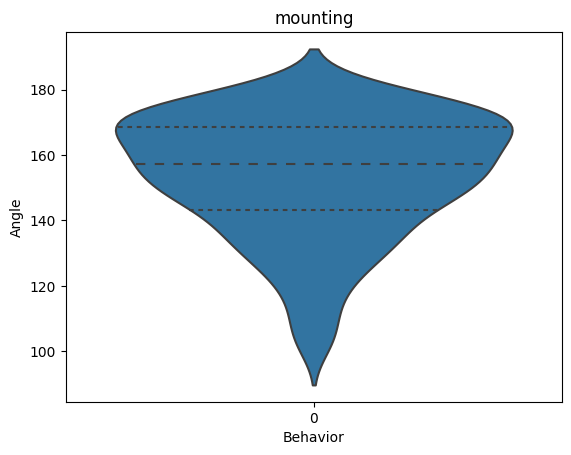

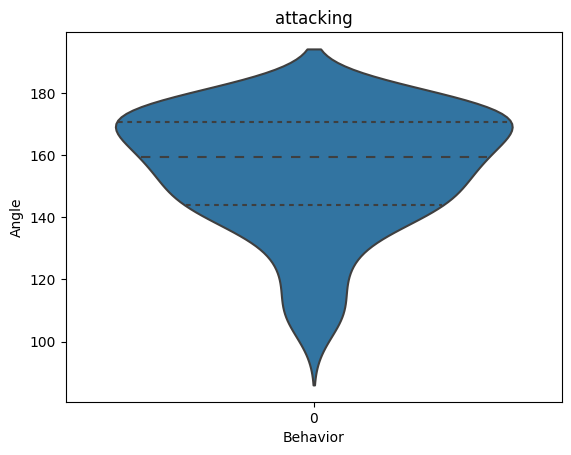

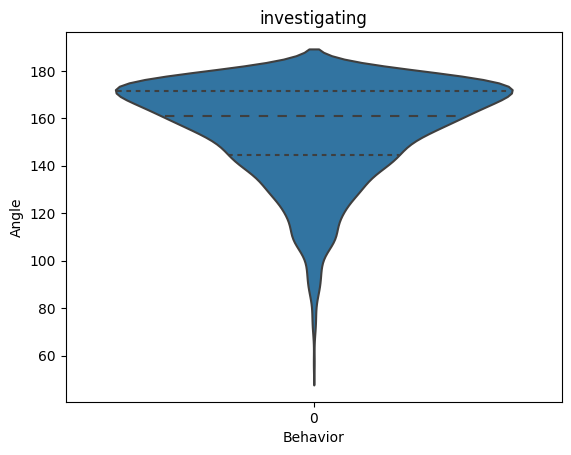

In [ ]:
#for Angle

import seaborn as sns
import matplotlib.pyplot as plt

# Create a dictionary to store combined data for each key
combined_angle_dict = find_combined_dict(net_angles_dict)

keys = list(combined_angle_dict.keys())

# Create a violin plot for each key in the dictionary
for key in keys:
    plt.figure()
    sns.violinplot(data=combined_angle_dict[key], inner='quart')
    plt.title(f"{key}")
    plt.xlabel("Behavior")
    plt.ylabel("Angle")
    plt.show()


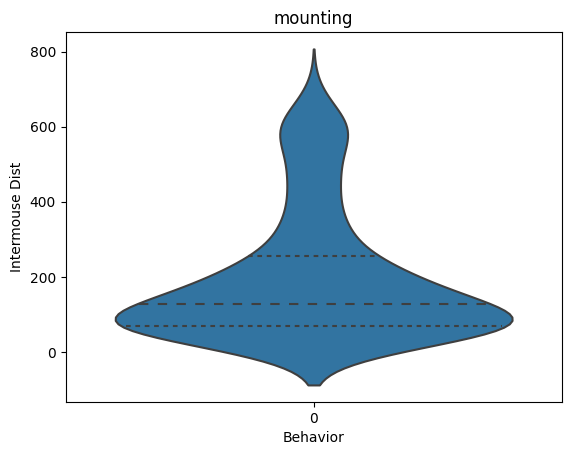

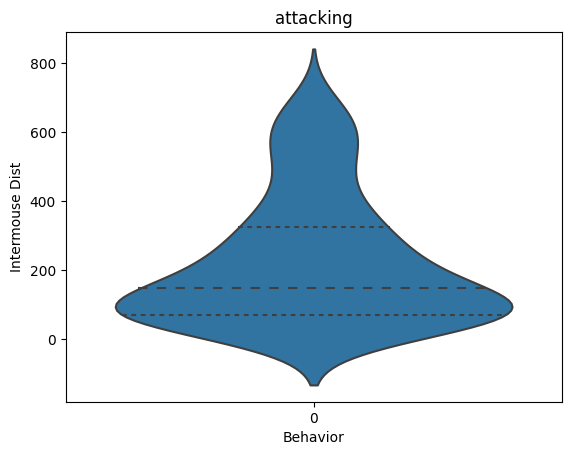

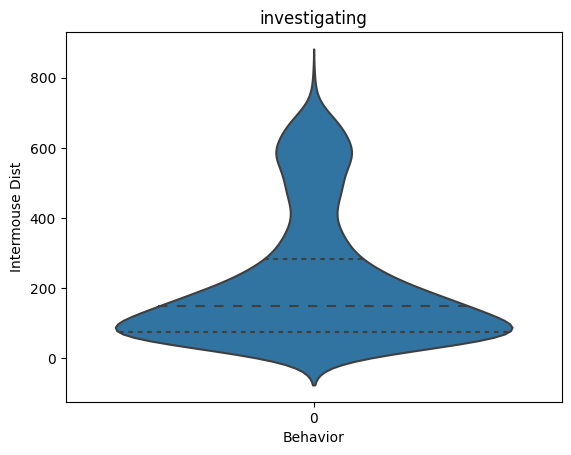

In [ ]:
#for Intermouse Distances

import seaborn as sns
import matplotlib.pyplot as plt

# Create a dictionary to store combined data for each key
combined_intermouse_dist_dict = find_combined_dict(net_intermouse_dist_dict)

keys = list(combined_intermouse_dist_dict.keys())

# Create a violin plot for each key in the dictionary
for key in keys:
    plt.figure()
    sns.violinplot(data=combined_intermouse_dist_dict[key], inner='quart')
    plt.title(f"{key}")
    plt.xlabel("Behavior")
    plt.ylabel("Intermouse Dist")
    plt.show()

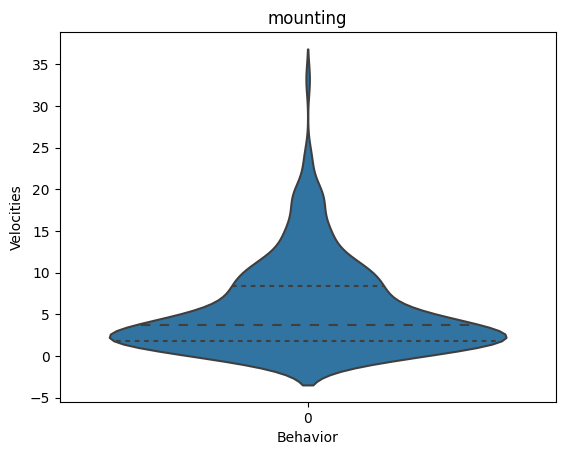

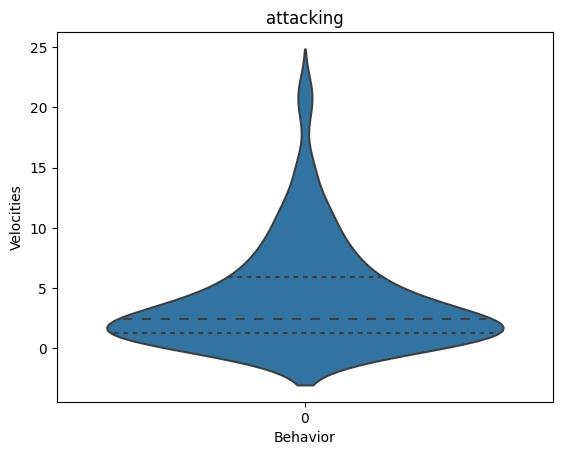

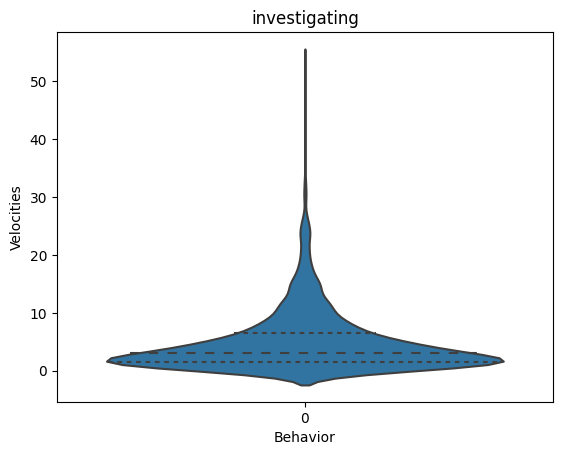

In [ ]:
#for Velocities

import seaborn as sns
import matplotlib.pyplot as plt

# Create a dictionary to store combined data for each key
combined_velocity_dict = find_combined_dict(net_velocity_dist_dict)

keys = list(net_velocity_dist_dict.keys())

# Create a violin plot for each key in the dictionary
for key in keys:
    plt.figure()
    sns.violinplot(data=combined_velocity_dict[key], inner='quart')
    plt.title(f"{key}")
    plt.xlabel("Behavior")
    plt.ylabel("Velocities")
    plt.show()

### Takeaways

> *Angles*: They don't seem to be particularly modulated by behaviour.

> *Distance*: The average of the distance when behaviour changes to mounting is quite a bit lower than for the other behaviours

> *Velocity*: The velocity of the mouse when investigating is far lower in both average and range than for the other behaviours

All these observations are in line with our intuition. There are likely other features that are worth investigating given more time

# Question 4 - Analysis of Behavioural Bouts

In [ ]:
def get_bout_idx(keypoint_seq,annot_seq):
  prev = None
  bout = []
  sectionize = {'attack':[i for i in range(len(annot_seq)) if number_to_class[annot_seq[i]=='attack']],
                'investigation':[i for i in range(len(annot_seq)) if number_to_class[annot_seq[i]=='investigation']],
                'mount':[i for i in range(len(annot_seq)) if number_to_class[annot_seq[i]=='mount']]}
  for k in sectionize.keys():
    sections = []
    section = []
    prev = None
    for i in range(len(sectionize[k])):
      if sectionize[k][i] != prev or prev is None:
        sections.append(section)
        section = []
      section.append(sectionize[k][i])
    sectionize[k] = sections
  return sectionize

def get_angle(coords):
  return getAngle(coords[0][3],coords[1][3],coords[0][0],coords[1][0],coords[0][6],coords[1][6])

def get_angle_section(keypoint_seq,indices):
  return [get_angle(keypoint_seq[idx][0]) for idx in indices]

def get_sep_section(keypoint_seq,indices):
  seps = []
  for idx in indices:
    frame = keypoint_seq[idx]
    resident = (np.mean(frame[0][0]),np.mean(frame[0][1]))
    intruder = (np.mean(frame[1][0]),np.mean(frame[1][1]))
    dist = np.linalg.norm((resident[0]-intruder[0],resident[1]-intruder[1]))
    seps.append(dist)
  return seps

def get_vel_section(keypoint_seq,indices):
  vels = []
  for idx in indices:
    frames = keypoint_seq[idx:idx+2]
    point1 = np.array((np.mean(frames[0][0][0]),np.mean(frames[0][0][1])),dtype=np.float16)
    point2 = np.array((np.mean(frames[0][0][0]),np.mean(frames[0][0][1])),dtype=np.float16)
    vel = np.linalg.norm(point1-point2)/2
    vels.append(vel)
  return vels

def get_features(behaviour_bout,keypoint_seq):
  features = defaultdict(list)
  for section in behaviour_bout:
    angle_section = get_angle_section(keypoint_seq,section)
    features['joint_angle'].append(angle_section)
    separation_section = get_sep_section(keypoint_seq,section)
    features['separation'].append(separation_section)
    velocity_section = get_vel_section(keypoint_seq,section)
    features['velocity'].append(velocity_section)
  return features

In [ ]:
for keypoint_seq,annot_seq in zip(new_keypoint_seq,new_annot_seq):
  sectionize = get_bout_idx(keypoint_seq,annot_seq)
  for k,v in sectionize.items():
    try:
        features = get_features(v,keypoint_seq)
    except:
        print(v)
    sectionize[k] = features

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


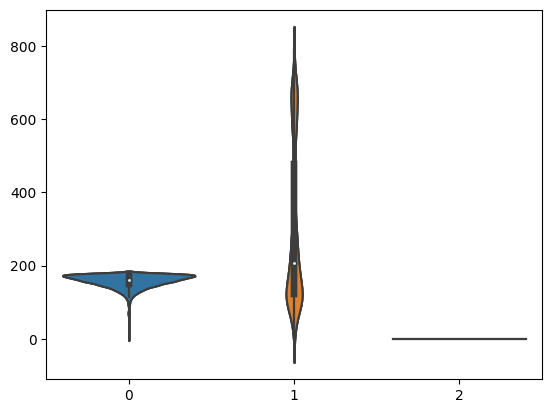

In [ ]:
import seaborn as sns
for behaviour,features in sectionize.items():
  avg_vals = []
  for feature,vals in features.items():
    avg_vals.append([np.mean(x) for x in vals])
  sns.violinplot(avg_vals)


### Takeaways
>

>
